# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [59]:
from importlib import reload
import utils
import simulate

reload(utils)
reload(simulate)

# now you can call your updated function
from simulate import backtest_strategy
from utils import plot_strategy_overview_multi
from utils import plot_strategy_overview



# Implementation Comments
***

Structure 

simulate.py contain the scripts to simulate a trading strategy, a script to check different sma treshold for trading

utils.py conain plotting functions for different signals/changes in equity

For more details about each function see the corresponding file

# Load data

In [25]:
df = pd.read_csv("BTCUSDT_price_data_2024-01-24-2.csv")
df["timestamp"] = df["timestamp"].astype(str).str.replace(r"[^0-9]", "", regex=True)
df["timestamp"] = df["timestamp"].astype(float) / 1000
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df = df.set_index("datetime")
df.head()

,timestamp,mid_price,volume
datetime,,,
2024-01-24 00:00:00,1.706054e+09,39881.95,439.561
2024-01-24 00:01:00,1.706054e+09,39926.55,776.492
2024-01-24 00:02:00,1.706055e+09,39877.05,339.306
2024-01-24 00:03:00,1.706055e+09,39927.45,246.511
2024-01-24 00:04:00,1.706055e+09,39926.55,423.920


## Task 1

In [26]:
df["p_t_minus_1"] = df["mid_price"].shift(1)
df["asset_return"] = ((df["mid_price"] - df["p_t_minus_1"]) / df["p_t_minus_1"]).fillna(0.0)

## Task 2

In [27]:
window = 10
df["sma"] = df["mid_price"].rolling(window=window).mean()

In [ ]:
## Move to a separate function
# df = simulate.compute_sma_signal(df, window=10)

## Task 3

In [29]:
df["signal"] = 0
df.loc[df["mid_price"] > df["sma"], "signal"] = 1
df.loc[df["mid_price"] < df["sma"], "signal"] = -1

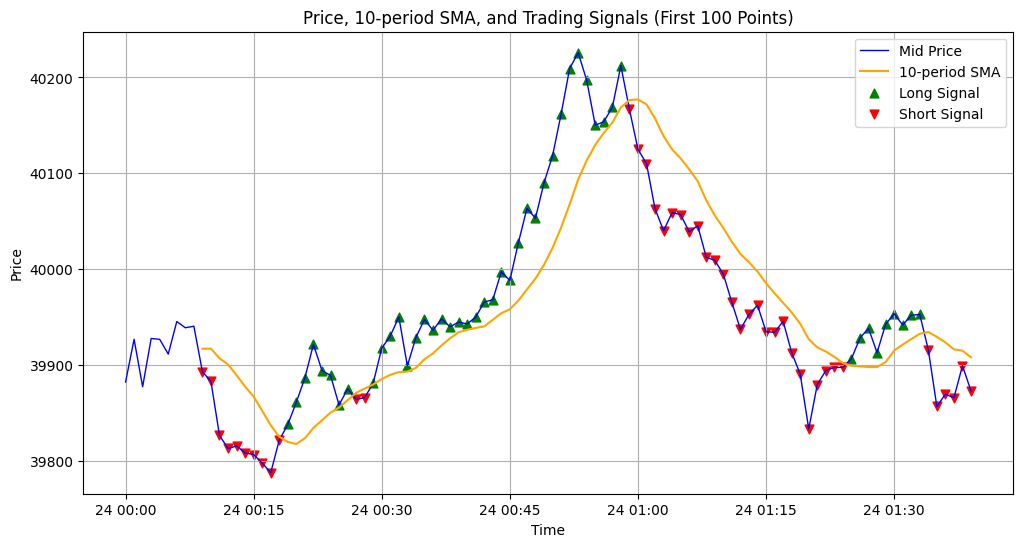

In [30]:
# --- Plot: Price, SMA, and Trading Signals (first 100 points) ---

subset = df.iloc[:100]

plt.figure(figsize=(12, 6))

plt.plot(subset.index, subset["mid_price"], label="Mid Price", color="blue", linewidth=1)
plt.plot(subset.index, subset["sma"], label="10-period SMA", color="orange", linewidth=1.5)

# Mark long and short signals
long_signals = subset[subset["signal"] == 1]
short_signals = subset[subset["signal"] == -1]

plt.scatter(long_signals.index, long_signals["mid_price"], label="Long Signal", color="green", marker="^", s=40)
plt.scatter(short_signals.index, short_signals["mid_price"], label="Short Signal", color="red", marker="v", s=40)

plt.title("Price, 10-period SMA, and Trading Signals (First 100 Points)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

## Task 4 - 5

In [31]:
transaction_cost_pct = 0.0
allow_short_enter = True
results,metrics = backtest_strategy(df,allow_short_enter=allow_short_enter, transaction_cost_pct=transaction_cost_pct)

Simulation
Initial capital: $100,000.00
Allow short enter: True
Transaction cost per side: 0.0000%
Results
------
Final equity: $102,585.49
Total return: 2.59%
Max drawdown: -2.06%
Number of trades: 225
Sharpe ratio: 21.026622685863547


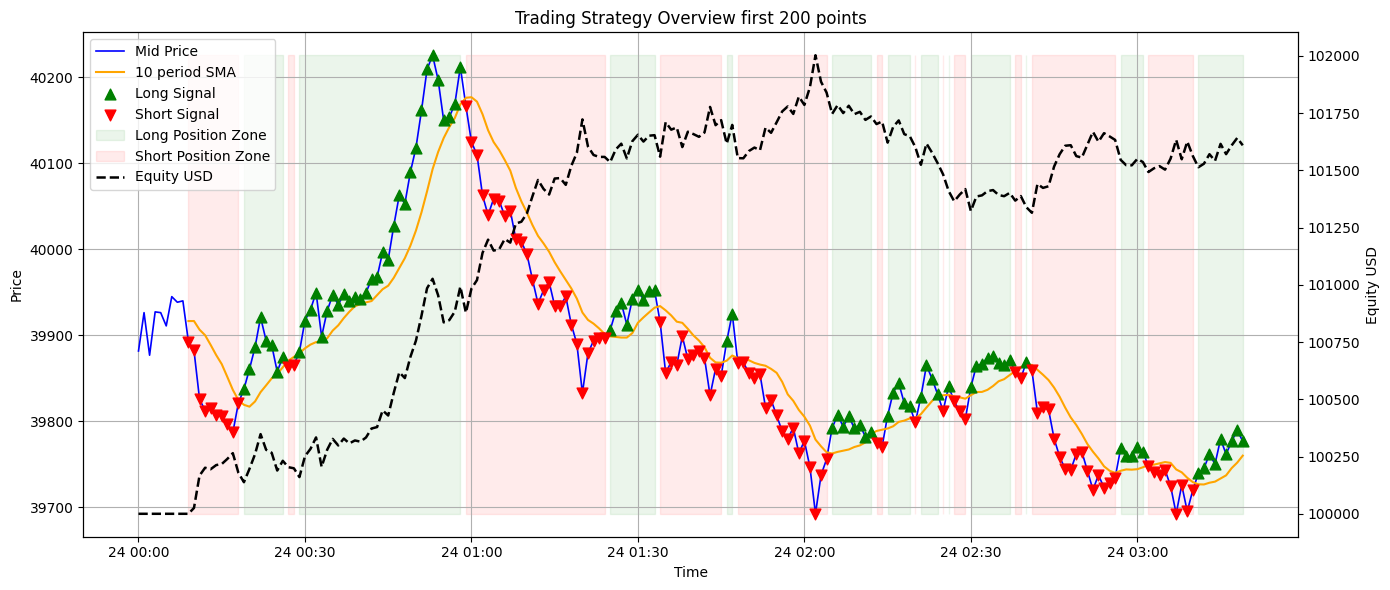

(<Figure size 1400x600 with 2 Axes>,
 <Axes: title={'center': 'Trading Strategy Overview first 200 points'}, xlabel='Time', ylabel='Price'>,
 <Axes: ylabel='Equity USD'>)

In [34]:
plot_strategy_overview(results, n_points=200)

# Task 6

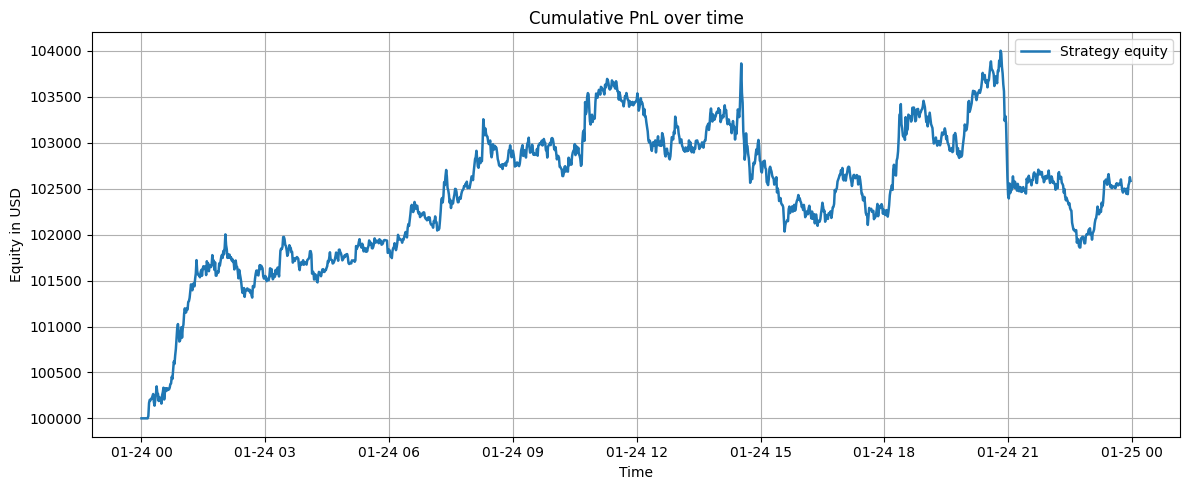

In [35]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df.index, results["equity"], label="Strategy equity", linewidth=1.8)
ax.set_title("Cumulative PnL over time")
ax.set_xlabel("Time")
ax.set_ylabel("Equity in USD")
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

## Task 7

In [36]:
transaction_cost_pct = 0.0002  # 0.02% per side
results_with_transaction_cost,metrics = backtest_strategy(df, allow_short_enter=True, transaction_cost_pct=transaction_cost_pct)

Simulation
Initial capital: $100,000.00
Allow short enter: True
Transaction cost per side: 0.0200%
Results
------
Final equity: $93,767.39
Total return: -6.23%
Max drawdown: -8.15%
Number of trades: 225
Sharpe ratio: -46.02985840495116


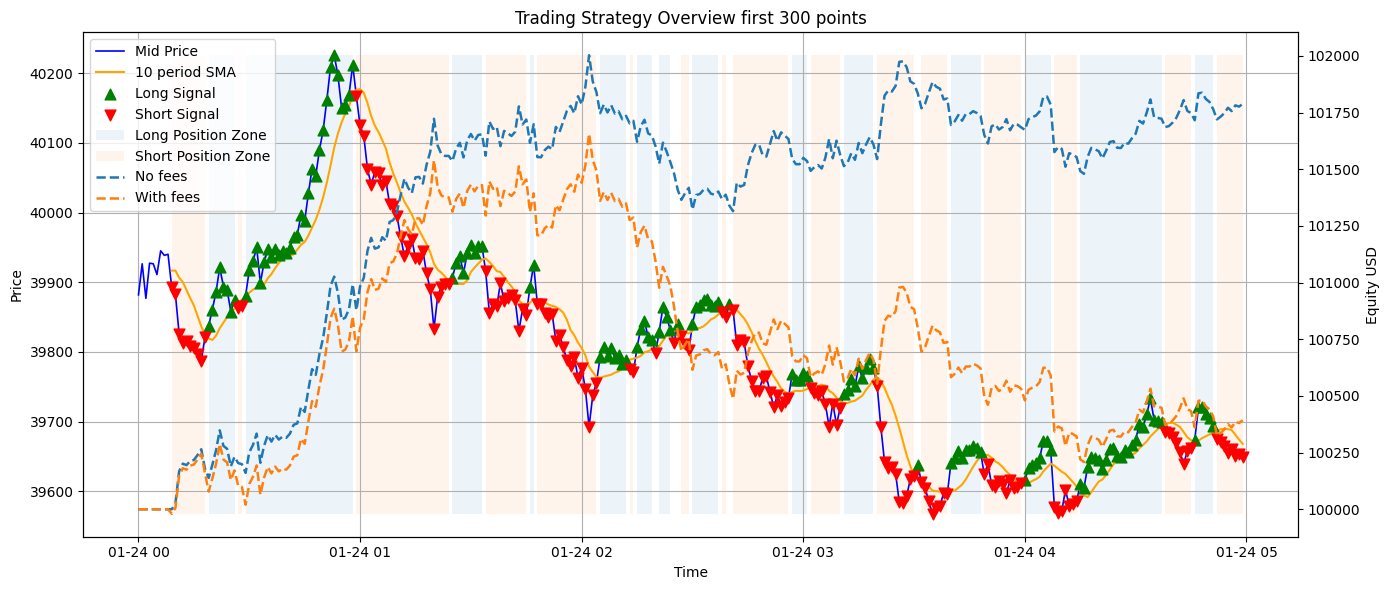

(<Figure size 1400x600 with 2 Axes>,
 <Axes: title={'center': 'Trading Strategy Overview first 300 points'}, xlabel='Time', ylabel='Price'>,
 <Axes: ylabel='Equity USD'>)

In [37]:
plot_strategy_overview_multi(
    results,
    equities={
        "No fees": results["equity"],
        "With fees": results_with_transaction_cost["equity"]
    },
    n_points=300
)

## Task 8

In [38]:
df = pd.read_csv("BTCUSDT_price_data_2024-01-24-2.csv")
df["timestamp"] = df["timestamp"].astype(str).str.replace(r"[^0-9]", "", regex=True)
df["timestamp"] = df["timestamp"].astype(float) / 1000
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")
df = df.set_index("datetime")
df.head()

,timestamp,mid_price,volume
datetime,,,
2024-01-24 00:00:00,1.706054e+09,39881.95,439.561
2024-01-24 00:01:00,1.706054e+09,39926.55,776.492
2024-01-24 00:02:00,1.706055e+09,39877.05,339.306
2024-01-24 00:03:00,1.706055e+09,39927.45,246.511
2024-01-24 00:04:00,1.706055e+09,39926.55,423.920


In [42]:
def compute_sma_signal(df, window):
    """Compute SMA and a price vs SMA signal on a copy, then return it."""
    out = df.copy()
    out["sma"] = out["mid_price"].rolling(window=window).mean()
    out["signal"] = 0
    out.loc[out["mid_price"] > out["sma"], "signal"] = 1
    out.loc[out["mid_price"] < out["sma"], "signal"] = -1
    return out

In [71]:
def run_sma_sweep(
    df,
    sma_periods=[5, 10, 20, 50],
    initial_capital=100_000.0,
    transaction_cost_pct=0.0002,
    allow_short_enter=False,
    backtest_func=None,
    price_col="mid_price",
    verbose=False,
):
    """
    Run multiple back tests over a set of SMA periods.
    Assumes `backtest_func` returns (df_result, metrics_dict).

    Returns
    -------
    metrics_df : pd.DataFrame
        One row per SMA period with final equity, total return, drawdown, Sharpe, and trades.
    results_by_period : dict[int, pd.DataFrame]
        Mapping from period to the full result dataframe of that run.
    equities : dict[str, pd.Series]
        Mapping from legend label to equity series, ready for plotting.
    """
    assert backtest_func is not None, "Please pass your backtest function via backtest_func"

    rows = []
    results_by_period = {}
    equities = {}

    for period in sma_periods:
        # period must be integer
        period = int(period)
        # prepare data for this period
        df_period = compute_sma_signal(df, window=period)

        # run back test
        df_res, metrics = backtest_func(
            df_period,
            sma_col="sma",
            price_col=price_col,
            signal_col="signal",
            initial_capital=initial_capital,
            allow_short_enter=allow_short_enter,
            transaction_cost_pct=transaction_cost_pct,
            verbose=verbose
        )

        # collect metrics with safe defaults
        final_equity = metrics.get("final_equity", float(df_res["equity"].iloc[-1]))
        total_return_pct = metrics.get("total_return_pct", None)
        max_drawdown_pct = metrics.get("max_drawdown_pct", None)
        sharpe = metrics.get("sharpe", None)
        num_trades = metrics.get("num_trades", metrics.get("trades", None))

        rows.append({
            "period": int(period),
            "final_equity": final_equity,
            "total_return_pct": total_return_pct,
            "max_drawdown_pct": max_drawdown_pct,
            "sharpe": sharpe,
            "num_trades": num_trades,
        })

        results_by_period[int(period)] = df_res
        equities[f"SMA {period}"] = df_res["equity"]

    metrics_df = pd.DataFrame(rows).set_index("period").sort_values("total_return_pct", ascending=False)
    return metrics_df, results_by_period, equities

In [84]:
sma_periods = np.arange(2,100,2)
metrics_df, results_by_period, equities = simulate.run_sma_sweep(
    df,
    sma_periods=sma_periods,
    initial_capital=100_000.0,
    transaction_cost_pct=0.000,
    allow_short_enter=True,
    backtest_func=backtest_strategy
)

In [79]:
metrics_df

,final_equity,total_return_pct,max_drawdown_pct,sharpe,num_trades
period,,,,,
12,103204.210993,3.204211,-1.628605,25.980698,193
10,102585.485067,2.585485,-2.060137,21.026623,225
8,102474.428188,2.474428,-2.040180,20.117902,268
6,102374.988572,2.374989,-2.152073,19.314332,316
26,101821.013334,1.821013,-1.469232,15.005150,123
20,101771.632451,1.771632,-1.479785,14.573973,143
4,101623.079040,1.623079,-3.079829,13.314806,424
14,101610.730029,1.610730,-1.865585,13.268292,179
16,101503.126306,1.503126,-1.795559,12.403434,163


In [87]:
metrics_df[metrics_df.index ==78]

,final_equity,total_return_pct,max_drawdown_pct,sharpe,num_trades
period,,,,,
78,100749.865708,0.749866,-2.516276,6.460787,68


/baja/utils.py:229: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.


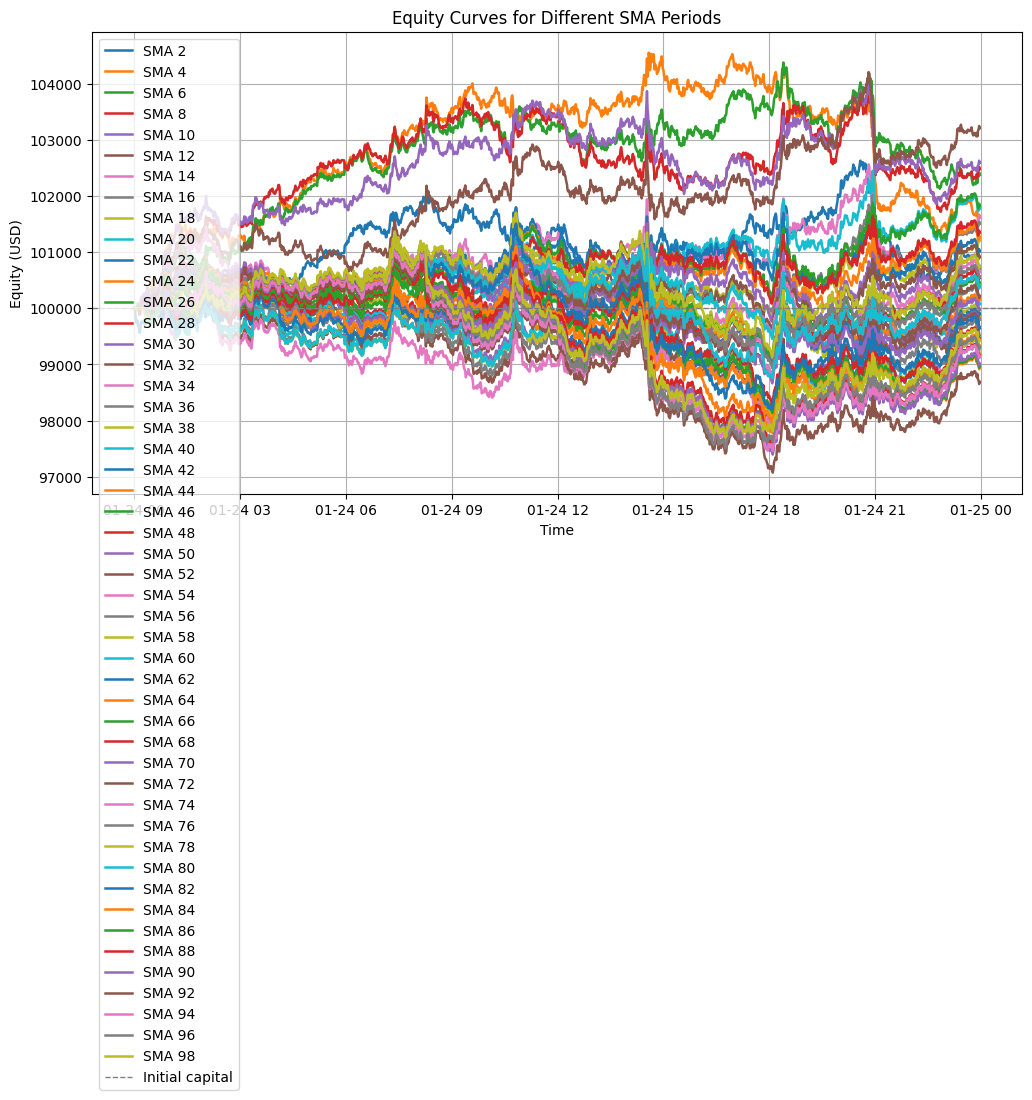

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Equity Curves for Different SMA Periods'}, xlabel='Time', ylabel='Equity (USD)'>)

In [80]:
# simple comparison plot
utils.plot_equity_curves(
    equities=equities,
    n_points=10000,
    title="Equity Curves for Different SMA Periods"
)

In [89]:
sma_periods = np.arange(2,100,2)
metrics_df, results_by_period, equities = simulate.run_sma_sweep(
    df,
    sma_periods=sma_periods,
    initial_capital=100_000.0,
    transaction_cost_pct=0.0002,
    allow_short_enter=True,
    backtest_func=backtest_strategy
)

In [90]:
metrics_df

,final_equity,total_return_pct,max_drawdown_pct,sharpe,num_trades
period,,,,,
78,98063.570589,-1.936429,-4.102303,-15.387074,68
76,97813.124841,-2.186875,-4.113541,-17.402855,70
80,97640.490470,-2.359510,-4.256443,-18.857262,70
74,97560.567199,-2.439433,-4.529059,-19.413520,72
72,97317.024497,-2.682976,-4.493960,-21.354481,74
26,96947.753942,-3.052246,-4.481183,-23.316787,123
70,96895.893135,-3.104107,-4.558698,-24.737910,79
82,96851.073321,-3.148927,-4.931622,-25.396244,72
84,96689.339534,-3.310660,-5.239470,-26.764488,68


In [92]:
metrics_df.mean(),metrics_df.std()

(final_equity        95225.341369
 total_return_pct       -4.774659
 max_drawdown_pct       -6.184578
 sharpe                -36.810531
 num_trades            132.510204
 dtype: float64,
 final_equity        3399.250676
 total_return_pct       3.399251
 max_drawdown_pct       3.150001
 sharpe                24.510611
 num_trades           107.179391
 dtype: float64)

/baja/utils.py:229: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.


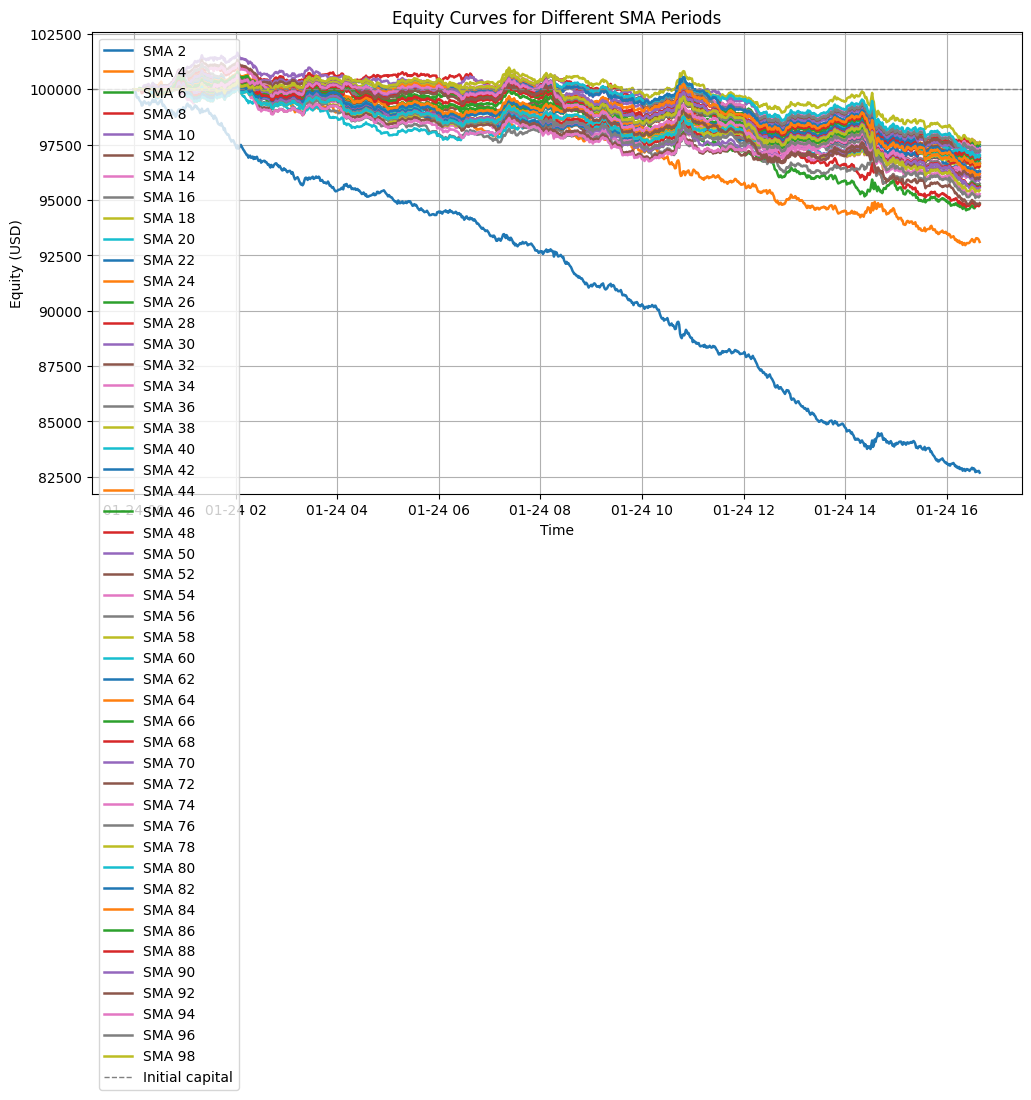

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'Equity Curves for Different SMA Periods'}, xlabel='Time', ylabel='Equity (USD)'>)

In [83]:
# simple comparison plot
utils.plot_equity_curves(
    equities=equities,
    n_points=1000,
    title="Equity Curves for Different SMA Periods"
)

## Additional Analysis

In [99]:
import numpy as np
import pandas as pd

def backtest_strategy(
    df,
    rule="price_sma",                 # "price_sma", "price_vwma", "sma_with_vol_ma_confirm", "sma_with_relvol_filter", "price_volume_divergence"
    price_col="mid_price",
    volume_col="volume",
    sma_window=10,
    vwma_window=10,
    vol_ma_window=20,
    relvol_window=20,
    relvol_threshold=1.5,
    div_window=20,                    # window for divergence slopes
    initial_capital=100_000.0,
    allow_short_enter=False,
    transaction_cost_pct=0.0002       # per side, for example 0.0002 equals 0.02 percent
):
    """
    Backtest an SMA family strategy with optional volume based rules.

    Returns
    -------
    df_out : pd.DataFrame
        Copy of df with columns: sma, vwma, vol_ma, rel_vol, signal, position, asset_return,
        strategy_return_gross, tx_cost, strategy_return, equity
    metrics : dict
        final_equity, total_return_pct, max_drawdown_pct, sharpe, num_trades
    """

    df = df.copy()

    # Core features
    df["sma"] = df[price_col].rolling(window=sma_window).mean()
    df["vol_ma"] = df[volume_col].rolling(window=vol_ma_window).mean()
    df["rel_vol"] = df[volume_col] / df["vol_ma"]

    # VWMA
    df["vwma_num"] = (df[price_col] * df[volume_col]).rolling(window=vwma_window).sum()
    df["vwma_den"] = df[volume_col].rolling(window=vwma_window).sum()
    df["vwma"] = df["vwma_num"] / df["vwma_den"]

    # Slopes for divergence idea
    # simple difference over window as a proxy for slope
    df["price_slope"] = df[price_col] - df[price_col].shift(div_window)
    df["vol_ma_slope"] = df["vol_ma"] - df["vol_ma"].shift(div_window)

    # Build signals for each rule
    signal = pd.Series(0.0, index=df.index)

    if rule == "price_sma":
        signal[df[price_col] > df["sma"]] = 1.0
        signal[df[price_col] < df["sma"]] = -1.0

    elif rule == "price_vwma":
        signal[df[price_col] > df["vwma"]] = 1.0
        signal[df[price_col] < df["vwma"]] = -1.0

    elif rule == "sma_with_vol_ma_confirm":
        # act only when volume confirms by being above its own moving average
        long_mask = (df[price_col] > df["sma"]) & (df[volume_col] > df["vol_ma"])
        short_mask = (df[price_col] < df["sma"]) & (df[volume_col] > df["vol_ma"])
        signal[long_mask] = 1.0
        signal[short_mask] = -1.0
        # otherwise stay flat

    elif rule == "sma_with_relvol_filter":
        # act only when relative volume exceeds a threshold
        long_mask = (df[price_col] > df["sma"]) & (df["rel_vol"] >= relvol_threshold)
        short_mask = (df[price_col] < df["sma"]) & (df["rel_vol"] >= relvol_threshold)
        signal[long_mask] = 1.0
        signal[short_mask] = -1.0

    elif rule == "price_volume_divergence":
        # start from a simple SMA signal
        base = pd.Series(0.0, index=df.index)
        base[df[price_col] > df["sma"]] = 1.0
        base[df[price_col] < df["sma"]] = -1.0

        # if price slope is up but volume slope is down, suppress longs
        suppress_long = (df["price_slope"] > 0) & (df["vol_ma_slope"] < 0)
        # if price slope is down and volume slope is up, keep or reinforce shorts
        confirm_short = (df["price_slope"] < 0) & (df["vol_ma_slope"] > 0)

        sig = base.copy()
        sig[suppress_long & (base > 0)] = 0.0
        sig[confirm_short & (base < 0)] = -1.0
        signal = sig

    else:
        raise ValueError(f"Unknown rule: {rule}")

    # Persist position over time with optional restriction on first entry
    signal_filled = signal.replace(0, np.nan).ffill()
    position = []
    in_position = False
    current_pos = 0.0
    for s in signal_filled:
        if pd.isna(s) or s == 0:
            pos = current_pos if in_position else 0.0
        else:
            if not in_position:
                if s == -1.0 and not allow_short_enter:
                    pos = 0.0
                else:
                    current_pos = float(s)
                    in_position = True
                    pos = current_pos
            else:
                if s != current_pos:
                    current_pos = float(s)
                pos = current_pos
        position.append(pos)

    df["signal"] = signal
    df["position"] = position

    # Returns and equity with costs
    df["asset_return"] = df[price_col].pct_change().fillna(0.0)
    df["strategy_return_gross"] = df["position"].shift(1).fillna(0.0) * df["asset_return"]

    pos_diff = df["position"].diff().fillna(0.0).abs()
    executed_sides = pos_diff                  # 0, 1, or 2
    df["tx_cost"] = executed_sides * transaction_cost_pct

    df["strategy_return"] = df["strategy_return_gross"] - df["tx_cost"]
    df["equity"] = (1.0 + df["strategy_return"]).cumprod() * initial_capital

    # Metrics
    trades = int((pos_diff > 0).sum())
    final_equity = float(df["equity"].iloc[-1])
    total_return_pct = (final_equity / initial_capital - 1.0) * 100.0
    rolling_max = df["equity"].cummax()
    drawdown = df["equity"] / rolling_max - 1.0
    max_drawdown_pct = float(drawdown.min() * 100.0)

    rets = df["strategy_return"].dropna()
    mu = rets.mean()
    sigma = rets.std(ddof=0)
    minutes_per_year = 365 * 24 * 60
    if sigma == 0 or np.isnan(sigma):
        sharpe = np.nan
    else:
        sharpe = float((mu / sigma) * np.sqrt(minutes_per_year))

    metrics = {
        "final_equity": final_equity,
        "total_return_pct": float(total_return_pct),
        "max_drawdown_pct": float(max_drawdown_pct),
        "sharpe": sharpe,
        "num_trades": trades,
        "rule": rule,
        "sma_window": sma_window,
        "vwma_window": vwma_window,
        "vol_ma_window": vol_ma_window,
        "relvol_window": relvol_window,
        "relvol_threshold": relvol_threshold,
        "div_window": div_window,
        "transaction_cost_pct": float(transaction_cost_pct),
        "allow_short_enter": bool(allow_short_enter),
    }

    return df, metrics


In [100]:
# Basic price vs SMA
df_price_sma, m1 = backtest_strategy(df, rule="price_sma", sma_window=10)

# Price vs VWMA
df_vwma, m2 = backtest_strategy(df, rule="price_vwma", vwma_window=20)

# SMA with volume moving average confirmation
df_confirm, m3 = backtest_strategy(df, rule="sma_with_vol_ma_confirm", sma_window=10, vol_ma_window=30)

# SMA with relative volume filter
df_relvol, m4 = backtest_strategy(df, rule="sma_with_relvol_filter", sma_window=10, relvol_window=30, relvol_threshold=1.5)

# Price volume divergence filter on top of SMA
df_div, m5 = backtest_strategy(df, rule="price_volume_divergence", sma_window=20, vol_ma_window=30, div_window=20)


In [106]:
import itertools
import pandas as pd

def run_rule_sweep(
    df,
    rule,
    sma_windows=None,
    vol_ma_windows=None,
    relvol_windows=None,
    relvol_thresholds=None,
    initial_capital=100_000.0,
    transaction_cost_pct=0.0002,
    allow_short_enter=False,
    price_col="mid_price",
    backtest_func=backtest_strategy,
):
    """
    Sweep parameter grids for a chosen rule and collect metrics and equity series.

    Returns
    -------
    metrics_df : pd.DataFrame
    results_by_cfg : dict[str, pd.DataFrame]
    equities : dict[str, pd.Series]
    """

    rows = []
    results_by_cfg = {}
    equities = {}

    if rule == "sma_with_vol_ma_confirm":
        assert sma_windows is not None and vol_ma_windows is not None, \
            "Provide sma_windows and vol_ma_windows for this rule"
        grid = itertools.product(sma_windows, vol_ma_windows)
        for sma_w, vol_w in grid:
            df_res, mets = backtest_func(
                df,
                rule=rule,
                price_col=price_col,
                sma_window=sma_w,
                vol_ma_window=vol_w,
                initial_capital=initial_capital,
                transaction_cost_pct=transaction_cost_pct,
                allow_short_enter=allow_short_enter,
            )
            label = f"m3 SMA{sma_w} VOL_MA{vol_w}"
            rows.append({
                "rule": rule,
                "sma_window": sma_w,
                "vol_ma_window": vol_w,
                "final_equity": mets["final_equity"],
                "total_return_pct": mets["total_return_pct"],
                "max_drawdown_pct": mets["max_drawdown_pct"],
                "sharpe": mets["sharpe"],
                "num_trades": mets["num_trades"],
            })
            results_by_cfg[label] = df_res
            equities[label] = df_res["equity"]

    elif rule == "sma_with_relvol_filter":
        assert sma_windows is not None and relvol_windows is not None and relvol_thresholds is not None, \
            "Provide sma_windows, relvol_windows, and relvol_thresholds for this rule"
        grid = itertools.product(sma_windows, relvol_windows, relvol_thresholds)
        for sma_w, rv_w, rv_thr in grid:
            df_res, mets = backtest_func(
                df,
                rule=rule,
                price_col=price_col,
                sma_window=sma_w,
                relvol_window=rv_w,
                relvol_threshold=rv_thr,
                initial_capital=initial_capital,
                transaction_cost_pct=transaction_cost_pct,
                allow_short_enter=allow_short_enter,
            )
            label = f"m4 SMA{sma_w} RV_W{rv_w} RV_T{rv_thr}"
            rows.append({
                "rule": rule,
                "sma_window": sma_w,
                "relvol_window": rv_w,
                "relvol_threshold": rv_thr,
                "final_equity": mets["final_equity"],
                "total_return_pct": mets["total_return_pct"],
                "max_drawdown_pct": mets["max_drawdown_pct"],
                "sharpe": mets["sharpe"],
                "num_trades": mets["num_trades"],
            })
            results_by_cfg[label] = df_res
            equities[label] = df_res["equity"]

    else:
        raise ValueError("This sweep helper is intended for m3 and m4 rules")

    metrics_df = pd.DataFrame(rows)
    sort_cols = ["total_return_pct", "sharpe"]
    sort_cols = [c for c in sort_cols if c in metrics_df.columns]
    if sort_cols:
        metrics_df = metrics_df.sort_values(sort_cols, ascending=[False] * len(sort_cols))
    metrics_df = metrics_df.reset_index(drop=True)
    return metrics_df, results_by_cfg, equities


,rule,sma_window,vol_ma_window,final_equity,total_return_pct,max_drawdown_pct,sharpe,num_trades
0,sma_with_vol_ma_confirm,20,50,100508.926230,0.508926,-2.000281,4.257295,58
1,sma_with_vol_ma_confirm,10,20,99180.057344,-0.819943,-3.367432,-6.122420,100
2,sma_with_vol_ma_confirm,50,50,98916.717886,-1.083282,-3.084236,-8.528973,44
3,sma_with_vol_ma_confirm,20,10,98755.820863,-1.244179,-2.560973,-9.448328,84
4,sma_with_vol_ma_confirm,20,20,98613.065039,-1.386935,-2.979557,-10.686619,74
5,sma_with_vol_ma_confirm,10,50,98339.906194,-1.660094,-3.390471,-12.760804,96
6,sma_with_vol_ma_confirm,10,10,97297.961000,-2.702039,-4.221344,-20.689369,112
7,sma_with_vol_ma_confirm,50,10,97133.299147,-2.866701,-4.606794,-22.853276,66
8,sma_with_vol_ma_confirm,50,20,97132.356179,-2.867644,-4.609998,-22.976191,56
9,sma_with_vol_ma_confirm,5,20,96369.174879,-3.630825,-4.623232,-27.720210,140


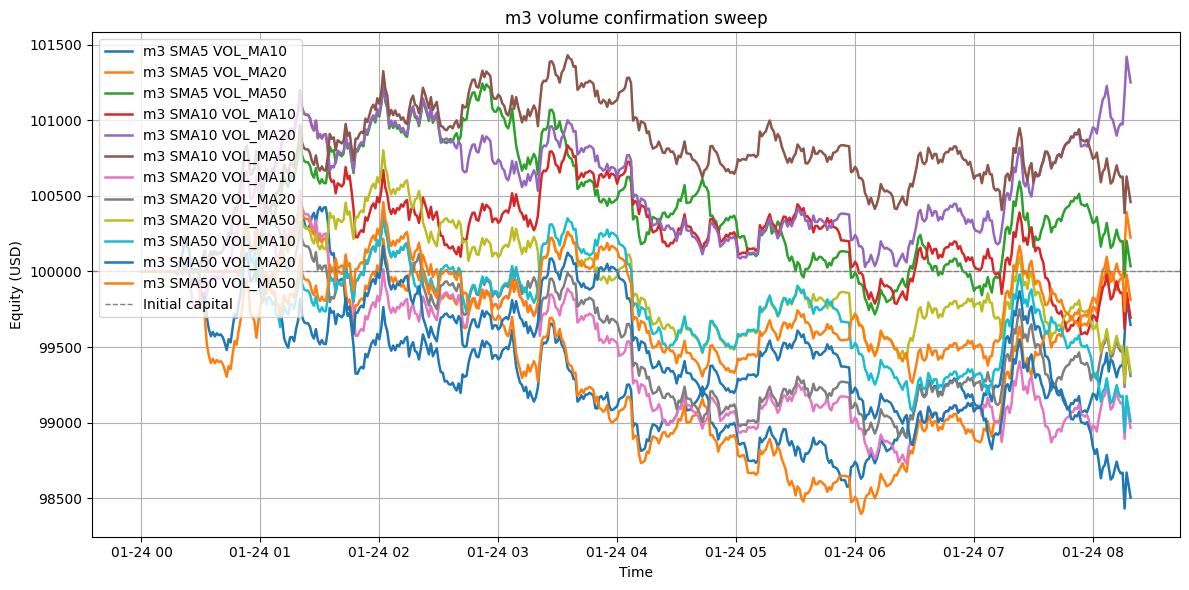

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'm3 volume confirmation sweep'}, xlabel='Time', ylabel='Equity (USD)'>)

In [107]:
metrics_m3, results_m3, equities_m3 = run_rule_sweep(
    df,
    rule="sma_with_vol_ma_confirm",
    sma_windows=[5, 10, 20, 50],
    vol_ma_windows=[10, 20, 50],
    initial_capital=100_000.0,
    transaction_cost_pct=0.0002,
    allow_short_enter=False,
)

display(metrics_m3)

# simple multi equity plot
plot_equity_curves(equities_m3, n_points=500, title="m3 volume confirmation sweep")


,rule,sma_window,relvol_window,relvol_threshold,final_equity,total_return_pct,max_drawdown_pct,sharpe,num_trades
0,sma_with_relvol_filter,20,20,1.2,100019.191958,0.019192,-1.810602,0.382334,52
1,sma_with_relvol_filter,20,30,1.2,100019.191958,0.019192,-1.810602,0.382334,52
2,sma_with_relvol_filter,20,50,1.2,100019.191958,0.019192,-1.810602,0.382334,52
3,sma_with_relvol_filter,10,20,1.2,98739.765706,-1.260234,-3.565060,-9.746362,70
4,sma_with_relvol_filter,10,30,1.2,98739.765706,-1.260234,-3.565060,-9.746362,70
5,sma_with_relvol_filter,10,50,1.2,98739.765706,-1.260234,-3.565060,-9.746362,70
6,sma_with_relvol_filter,50,20,1.2,98585.336071,-1.414664,-3.055687,-11.198096,46
7,sma_with_relvol_filter,50,30,1.2,98585.336071,-1.414664,-3.055687,-11.198096,46
8,sma_with_relvol_filter,50,50,1.2,98585.336071,-1.414664,-3.055687,-11.198096,46
9,sma_with_relvol_filter,50,20,2.0,98475.909298,-1.524091,-2.813914,-12.302773,21


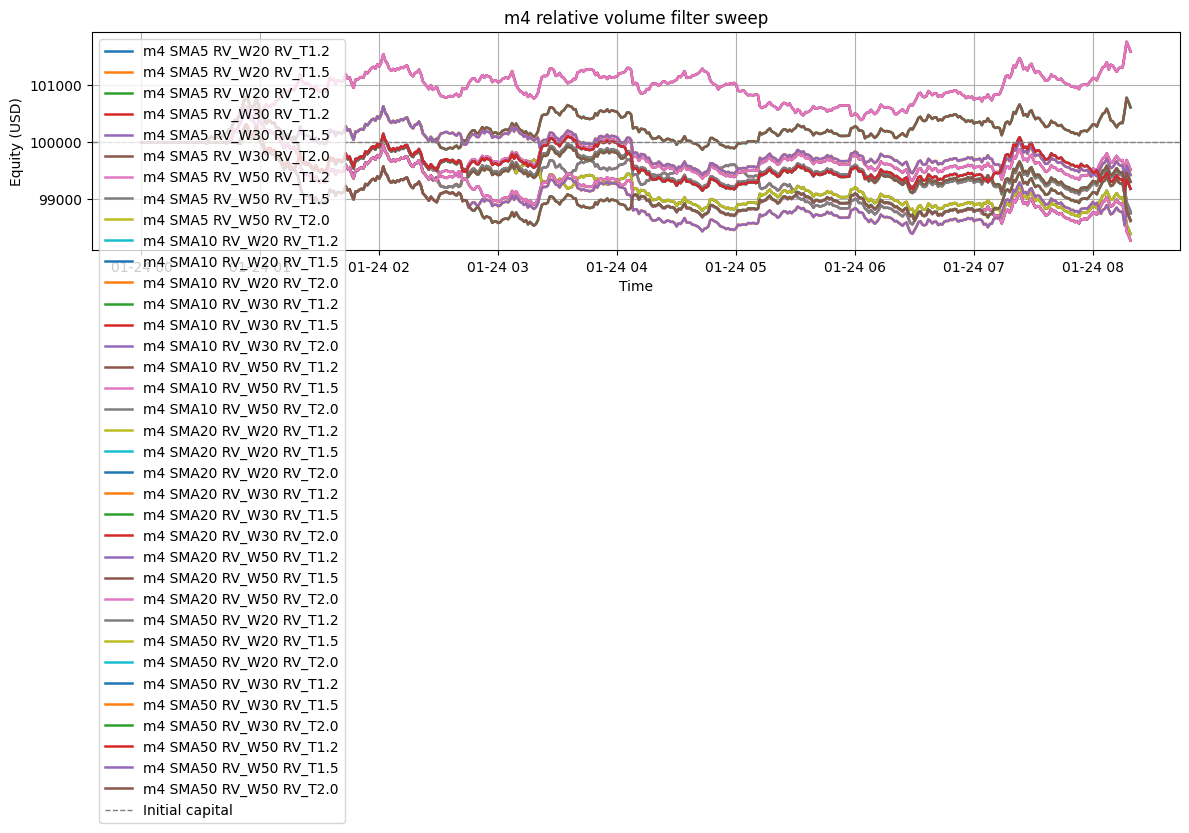

(<Figure size 1200x600 with 1 Axes>,
 <Axes: title={'center': 'm4 relative volume filter sweep'}, xlabel='Time', ylabel='Equity (USD)'>)

In [108]:
metrics_m4, results_m4, equities_m4 = run_rule_sweep(
    df,
    rule="sma_with_relvol_filter",
    sma_windows=[5, 10, 20, 50],
    relvol_windows=[20, 30, 50],
    relvol_thresholds=[1.2, 1.5, 2.0],
    initial_capital=100_000.0,
    transaction_cost_pct=0.0002,
    allow_short_enter=False,
)

display(metrics_m4)

plot_equity_curves(equities_m4, n_points=500, title="m4 relative volume filter sweep")


# Comments about results
***
- **General behavior:**  
  The SMA-based strategy behaves as expected for a simple trend-following system.  
  When the price crosses above the moving average, the model goes long; when it drops below, it goes short.  
  This produces steady gains during clear trends and flat or negative results in sideways flat markets.

- **Effect of SMA period:**  
  - Shorter SMAs (e.g., 5 or 10) react faster to price changes, leading to more frequent trades.  
    They capture small, quick moves but are also more exposed to noise and false signals.  
  - Longer SMAs (e.g., 50 or 100) are smoother and less sensitive to short-term fluctuations,  
    which reduces the number of trades and transaction costs but introduces lag in reacting to new trends.

- **Performance comparison:**  
  - Without transaction costs: 12 SMA leading to 3.2% increase in returns
  - With transaction costs: 78 SMA leading to 1.9% loss.

- **Impact of transaction costs:**  
  - Adding fee per trade removed profitability for short-term strategies.  
  - The effect was smaller for long-horizon SMAs with fewer trades, confirming that  
    transaction costs are a key limiting factor for high-frequency trend rules.


- **Risk metrics:**  
  - The maximum drawdown values were reasonable (considering transaction costs) on average 6% (+-3%).
  Indicating that even tho the position was always 100% long or short the worst temporary loss was below 6%.
  - The Sharpe ratio turned **negative** once transaction costs were added.  
  - The strategy not only lost money, it did so with volatility that was not compensated by return.


- **Conclusion:**  
  The SMA strategy offers simple, interpretable behavior with performance highly dependent on the chosen period.  
  The analysis highlights the trade-off between reactivity and robustness,  
  and the strong influence of transaction costs on short-horizon trading strategies.
  - The analysis emphasizes the need for:
  - Lower trading frequency (using longer SMA windows)
  - Reduced fees or slippage
  - Better signal filtering to avoid noise trades

# End